In [72]:
import torch.nn as nn
import torch
import numpy as np
from torch import exp, where, erf, tensor, sin, cos, log 
from torch import pow as POW
from numpy import pi
import matplotlib.pyplot as plt

In [73]:
#https://arxiv.org/abs/2112.11687
#custom grad activation function helper for squareplus
class squarePlus_helper(torch.autograd.Function):
        
    @staticmethod
    def forward(ctx, data:tensor):

        val = POW(data, 2) + 1/4
        
        ctx.save_for_backward(data, val)

        return 0.5*(POW(val, 0.5) + data) 
        
    @staticmethod
    def backward(ctx, grad_output:tensor):

        (data, val) = ctx.saved_tensors

        grad = 0.5*(1 + data*POW(val, -0.5))
        
        return grad*grad_output

class squarePlus(nn.Module):

    def __init__(self) -> None:
        super(squarePlus, self).__init__()
        self.fn =  squarePlus_helper.apply

    def forward(self, x) -> tensor:

        return self.fn(x)

In [74]:
#https://arxiv.org/abs/2306.01822
#custom grad activation function helper for erf plus
class softplus_helper(torch.autograd.Function):
        
    @staticmethod
    def forward(ctx, data:tensor):
        
        b = 4 
        
        val = exp(b*data)
        
        ctx.save_for_backward(val)

        return log(1+val)/b 
        
    @staticmethod
    def backward(ctx, grad_output:tensor):
        
        (val, ) = ctx.saved_tensors

        grad = val/(1+val) 
        
        return grad*grad_output

#Our custom grad function as a nn.Module 
class softplus(nn.Module):

    def __init__(self) -> None:
        super(softplus, self).__init__()
        self.fn = softplus_helper.apply

    def forward(self, x) -> tensor:

        return self.fn(x)

In [75]:
#https://arxiv.org/abs/2306.01822
#custom grad activation function helper for erf plus
class erfRelu_helper(torch.autograd.Function):
        
    @staticmethod
    def forward(ctx, data:tensor):
        
        a = 1/np.sqrt(2)

        b = np.sqrt(np.pi)/2/a
        
        ctx.save_for_backward(data)

        return where(data < 0, b*erf(a*data), data)
        
    @staticmethod
    def backward(ctx, grad_output:tensor):
        
        a = 1/np.sqrt(2)

        b = np.sqrt(np.pi)/2/a
        
        (data, ) = ctx.saved_tensors

        grad = where(data < 0, 2/np.sqrt(np.pi)*a*b*exp(-POW(a*data, 2)), 1)
        
        return grad*grad_output

#Our custom grad function as a nn.Module 
class erfRelu(nn.Module):

    def __init__(self) -> None:
        super(erfRelu, self).__init__()
        self.fn = erfRelu_helper.apply

    def forward(self, x) -> tensor:

        return self.fn(x)

In [76]:
#Our custom grad activation function helper for erf plus
class erfPlus_helper(torch.autograd.Function):
        
    @staticmethod
    def forward(ctx, data:tensor):
        
        a = 16/np.sqrt(np.pi)*np.exp(-2)
        
        grad = where(data < 0, -erf(a*POW(data, -1)), 1)
        
        ctx.save_for_backward(data, grad)

        return data*grad
        
    @staticmethod
    def backward(ctx, grad_output:tensor):
        
        a = 16/np.sqrt(np.pi)*np.exp(-2)

        (data, grad) = ctx.saved_tensors

        val = a*POW(data, -1)

        grad = grad + where(data < 0, 2/np.sqrt(np.pi)*val*exp(-POW(val, 2)), 0)
        
        return grad*grad_output

#Our custom grad function as a nn.Module 
class erfPlus(nn.Module):

    def __init__(self) -> None:
        super(erfPlus, self).__init__()
        self.fn = erfPlus_helper.apply

    def forward(self, x) -> tensor:

        return self.fn(x)

In [77]:

#Our custom grad activation function helper for erf plus
class gelu_helper(torch.autograd.Function):
        
    @staticmethod
    def forward(ctx, data:tensor):
        
        a = np.pi**(1/4)/2
        
        b = 1/2
        
        val = b*(1 + erf(a*data))
        
        ctx.save_for_backward(data, val)

        return data*val 
        
    @staticmethod
    def backward(ctx, grad_output:tensor):
        
        a = np.pi**(1/4)/2
        
        b = 1/2
        
        (data, grad) = ctx.saved_tensors
        
        grad = grad + 2/np.sqrt(np.pi)*b*a*data*exp(-POW(a*data, 2))
        
        return grad*grad_output

#Our custom grad function as a nn.Module 
class gelu(nn.Module):

    def __init__(self) -> None:
        super(gelu, self).__init__()
        self.fn = gelu_helper.apply

    def forward(self, x) -> tensor:

        return self.fn(x)

In [78]:
#https://arxiv.org/abs/2112.11687
#custom grad activation function helper for squareplus
class degreePlus_helper(torch.autograd.Function):
        
    @staticmethod
    def forward(ctx, data:tensor):

        a = 2*4

        val = POW(data, a) + 1
        
        ctx.save_for_backward(data, val)

        return 0.5*(POW(val, 1/a) + data) 
        
    @staticmethod
    def backward(ctx, grad_output:tensor):

        a = 2*4 

        (data, val) = ctx.saved_tensors

        grad = 0.5*(1 + data**(a-1)*POW(val, 1/a-1))
        
        return grad*grad_output

class degreePlus(nn.Module):

    def __init__(self) -> None:
        super(degreePlus, self).__init__()
        self.fn =  degreePlus_helper.apply

    def forward(self, x) -> tensor:

        return self.fn(x)

In [83]:
c = 1

In [84]:
if c == 1: 

    actFuncs = [erfPlus(), erfRelu(), squarePlus(), degreePlus(), gelu(), softplus()] 
    #Test function and to see if backward works 
    torch.manual_seed(3)
    
    data = torch.randn(50, dtype=torch.float64, requires_grad=True) 
            
    for actFunc in actFuncs:

        try: 
            torch.autograd.gradcheck(actFunc, data, eps=1e-8, atol=1e-7) 
            print(f'Gradient function {str(actFunc)} is correct')
        except: 
            print(f'Gradient function {str(actFunc)} is NOT correct')

Gradient function erfPlus() is correct
Gradient function erfRelu() is correct
Gradient function squarePlus() is correct
Gradient function degreePlus() is correct
Gradient function gelu() is correct
Gradient function softplus() is correct


In [85]:
#torch.autograd.gradcheck(testing_actFunc, data, eps=1e-8, atol=1e-7)

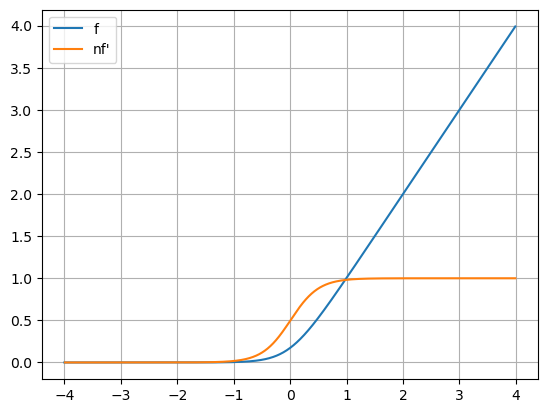

In [86]:
#Test if the function plots correct graph 
if c == 1: 
    dt = 0.01
    testing_actFunc = softplus()
    
    datax = torch.arange(-4, 4, dt, dtype=torch.float64, requires_grad=True) 
    
    datay = testing_actFunc.forward(datax)

    datad = (datay[1:]-datay[:-1])/dt
    
    plt.plot(datax.detach().numpy(), datay.detach().numpy(), label="f")
    plt.plot(datax[1:].detach().numpy(), datad.detach().numpy(), label="nf'")
    plt.grid()
    plt.legend()
    plt.show()